# Titanic Competition

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
%matplotlib inline

In [2]:
#ml imports
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
#pwd

In [4]:
#with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
#    zip_ref.extractall('C:\\Users\\SamPe\\Docs\\Data\\Titanic_Project\\kaggle_Titanic')

# Data Exploration

In [65]:
df = pd.read_csv('.\\Data\\train.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:xlabel='Survived', ylabel='count'>

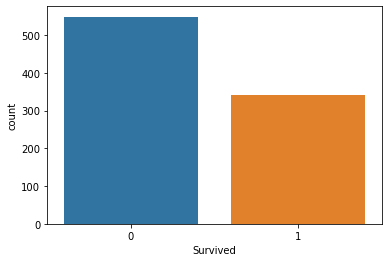

In [9]:
#survived is the label
#sibsp and parch can be combined to form a family metric
sns.countplot(data=df,x='Survived')

The labels are imbalanced, so we will focus more on precision and recall when we evaluate

In [10]:
#exploratory correlation plot

<AxesSubplot:>

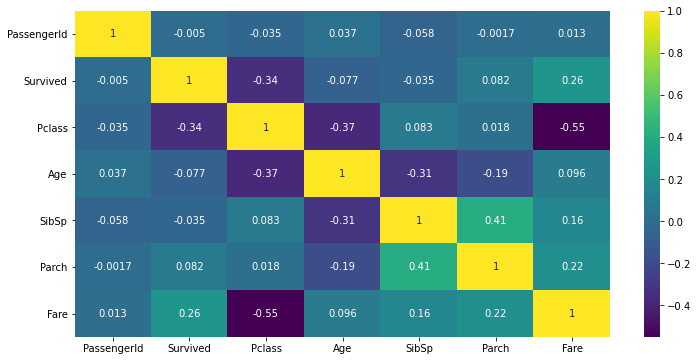

In [11]:
plt.figure(figsize=(12,6))
sns.heatmap(data=df.corr(),annot=True,cmap='viridis')

Pclass and Fare have significant correlation with the label of the numeric columns, Sex and Embarked are good candidates to explore among the other labels.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

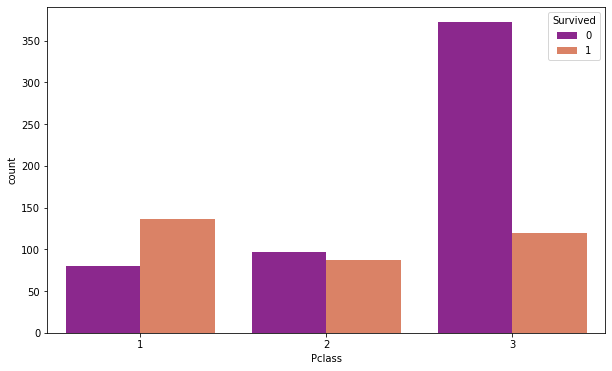

In [12]:
#Pclass
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Pclass',hue='Survived',palette='plasma')

Passengers in the first or second class were much more likely than third class passengers to survive

<Figure size 864x576 with 0 Axes>

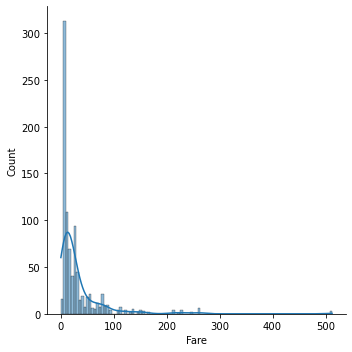

In [35]:
#Fare is strongly related to passenger class, so we will explore their relationship with each other as well
plt.figure(figsize=(12,8))
sns.displot(data=df, kind='hist',x='Fare',kde=True)

In [50]:
#Most values are under 100, and there are some outliers above that. I will find the value at the 10th percentile
#and adjust the outliers to that value because there is a significant jump from 20th to 10th percentile
df['Fare'].quantile(np.linspace(.1, 1, 9, 0), 'lower')

0.1     7.5500
0.2     7.8542
0.3     8.0500
0.4    10.5000
0.5    14.4542
0.6    21.6792
0.7    27.0000
0.8    39.6875
0.9    77.9583
Name: Fare, dtype: float64

In [51]:
len(df) * .1

89.10000000000001

In [66]:
#replaces fare to 90th perentile plus an arbitrary scalar adjustment so that they keep their positions but - 
#do not affect the distribution too heavily
def replace_fare(fare):
    if (fare > 77.9583):
        return 78 + (fare/10)
    else:
        return fare

In [67]:
df['Fare'] = df['Fare'].apply(lambda x: replace_fare(x))

In [68]:
#Fare is adjusted for outliers now
df['Fare'].describe()

count    891.000000
mean      26.919141
std       27.053551
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      129.232920
Name: Fare, dtype: float64

<Figure size 864x576 with 0 Axes>

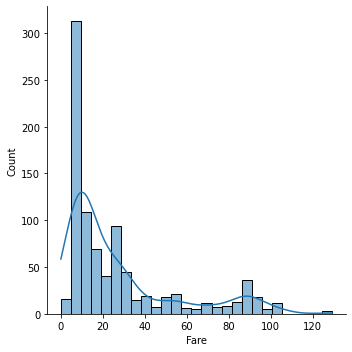

In [69]:
plt.figure(figsize=(12,8))
sns.displot(data=df, kind='hist',x='Fare',kde=True)

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Sex',hue='Survived')

We can see that Sex has a significant impact on the label

In [ ]:
df['Embarked'].value_counts()

In [ ]:
sns.countplot(data=df,x='Embarked',hue='Survived')

The embarked column also has significant impact on the label

In [ ]:
#explore variables relationships with each other
sns.pairplot(data=df,hue='Survived')